In [369]:
import sys
sys.path.append('C:/Users/Leo/Projects/neural_analysis/neural_analysis')

# Standard PyData imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})

### Spectral analysis using spectra module ###
from neural_analysis.spectra import remove_evoked, spectrogram, pool_freq_bands, one_over_f_norm, plot_spectrogram

print("Imports successful")

Imports successful


In [453]:
### Data loading from mat file using matIO module ###
from neural_analysis.matIO import loadmat

# Load some data from a mat file into Python variables
filename = r'//millerdata.mit.edu/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'

trial_info,lfp,session_info = loadmat(filename, variables=['trialInfo','lfp','sessionInfo'])

# Alternatively, we could load all variables into a Python dictionary (similar to Matlab struct) 
# with variable names as keys (fields)
# data = loadmat(filename, variables=['trialInfo','spikeTimes','lfp','lfp_timepts], asdict=True)

trialInfo : dict with keys[Properties,badTimingTrials,badTrials,cpt_puffOff,cpt_puffOn,cpt_refTime,cpt_toneOff,cpt_toneOn,cpt_trialType,dbs_amplitude,dbs_amplitude2,dbs_anodes,dbs_bodyScore,dbs_cathodes,dbs_drugPhase,dbs_duration,dbs_eyeScore,dbs_frequency,dbs_isStandard,dbs_isWakeUpTest,dbs_previousITI,dbs_puffScore,dbs_stimOff,dbs_stimOn,dbs_testType,dbs_timingType,dbs_wakeScore,dbs_width1,dbs_width2,drugPhase,drugPhaseTime,refTime,session,task,trial,trialStart,]

lfp : numpy.array(10384629,264,) of type float64

sessionInfo : dict with keys[NSPs,Properties,areas,arrays,drug,drugDose,drugDuration,drugEnd,drugStart,drugTask,eyesClose,eyesOpen,hasDrug,hasWakeUpTest,numCorrect,numTrials,pctBadTrials,pctCorrect,session,subject,tasks,]



In [454]:
electrode_info = loadmat(filename,variables = ['electrodeInfo'])


electrodeInfo : dict with keys[NSP,Properties,area,array,channel,chnlID,electrode,file,gridLoc,hasLFP,hemisphere,numUnits,session,]



array([1875.35996667, 3675.35996667])

In [ ]:


# Compute wavelet power spectrogram for each electrode (with logarithmic frequency sampling)
spec_wave, f_wave, t_wave = spectrogram(lfp_chunk, smp_rate=1000, axis=0, method='wavelet', spec_type='power',
                                        freqs=2**np.arange(1,7,0.2), downsmp=10)

print("Wavelet spectrogram (frequency,time,electrodes,trials): ", spec_wave.shape)



In [ ]:
# Compute multitaper power spectrogram (sampling from 2-100 Hz, with 0.5 s time, 4 Hz freq bandwidth)
spec_mt, f_mt, t_mt = spectrogram(lfp_chunk, smp_rate=1000, axis=0, method='multitaper', spec_type='power',
                                  freq_range=[2,100], time_width=0.5, freq_width=4, n_tapers=3, spacing=0.1)

print("Multitaper spectrogram (frequency,time,electrodes,trials): ", spec_mt.shape)

In [ ]:


# spectrogram returns time sampling referenced to start of input data. Convert to actual times.
t_wave += lfp_timepts[0]
t_mt += lfp_timepts[0]

# Normalize time-frequency data to correct for 1/f baseline distribution of power
spec_wave   = one_over_f_norm(spec_wave, axis=0, freqs=f_wave)
spec_mt     = one_over_f_norm(spec_mt, axis=0, freqs=f_mt)

# Pool wavelet and multitaper spectrograms by frequency band (theta, beta, and gamma)
band_names = ['theta','beta','gamma']
bands = np.asarray([[3,8],[12,30],[40,80]])
spec_wave_band = pool_freq_bands(spec_wave, bands, axis=0, freqs=f_wave)
spec_mt_band = pool_freq_bands(spec_mt, bands, axis=0, freqs=f_mt)

print("Wavelet band-pooled (frequency bands,time,electrodes,trials): ", spec_wave_band.shape)
print("Multitaper band-pooled (frequency bands,time,electrodes,trials): ", spec_mt_band.shape)

In [ ]:
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

In [ ]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))

In [342]:
from statsmodels.tsa.api import VAR

def get_stab_from_AR(data_chunk):
    
    model = VAR(data_chunk)
    
    results = model.fit(1)
    
    e,_ = np.linalg.eig(results.coefs[0,:,:])      
    
    return np.abs(np.real(e))




In [ ]:
results.r

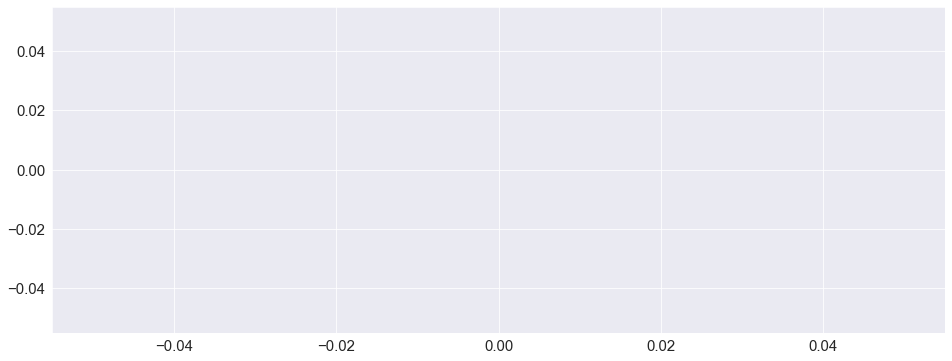

In [477]:
plt.plot(lfp[10000:1000,0])

In [478]:
from tqdm.auto import tqdm


def get_stab_over_session(lfp,window,area):
    
    all_eigs = []

    T = lfp.shape[0]

    electrode_inds = np.where(electrode_info['area'] == area)[0]
    
    for t in tqdm(np.arange(0,T,window)):         

        lfp_chunk_df = pd.DataFrame(lfp[t:t+window,electrode_inds])
        eigs =  get_stab_from_AR(lfp_chunk_df)
        all_eigs.append(eigs)

    all_eigs = np.stack(all_eigs)    
    
    return all_eigs


array(['vlPFC', 'FEF', 'CPB', '7b'], dtype=object)

In [479]:
window = 5000
all_eigs_areas = []
for area in session_info['areas']:
    all_eigs = get_stab_over_session(lfp,window,area)
    all_eigs_areas.append(all_eigs)

  0%|          | 0/2077 [00:00<?, ?it/s]

  0%|          | 0/2077 [00:00<?, ?it/s]

  0%|          | 0/2077 [00:00<?, ?it/s]

  0%|          | 0/2077 [00:00<?, ?it/s]

  0%|          | 0/2077 [00:00<?, ?it/s]

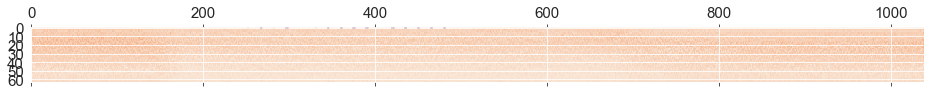

In [461]:
plt.matshow(all_eigs_areas[3].T)

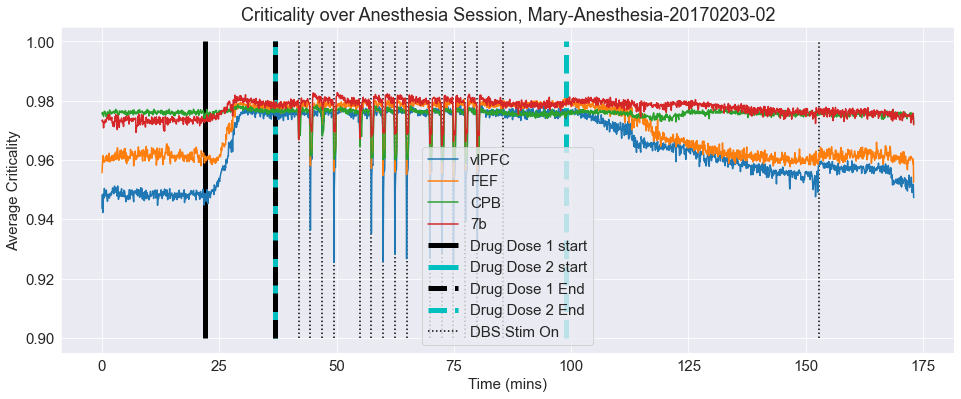

In [480]:
plt.rcParams.update({'font.size': 15})

tvec = np.arange(0,lfp.shape[0],window)
tvec_in_s = tvec/(1000)
tvec_in_mins = tvec/(60*1000)

drug_start_times = session_info['drugStart']
drug_end_times = session_info['drugEnd']

drug_start_in_s = drug_start_times.copy()
drug_start_in_ms = 1000*drug_start_in_s
drug_start_in_min = drug_start_in_s/60

drug_end_times_in_ms = 1000*drug_end_times
drug_end_times_in_min = drug_end_times/60

plt.plot(tvec_in_mins,np.mean(all_eigs_areas[0],1),label = session_info['areas'][0])
plt.plot(tvec_in_mins,np.mean(all_eigs_areas[1],1),label = session_info['areas'][1])
plt.plot(tvec_in_mins,np.mean(all_eigs_areas[2],1),label = session_info['areas'][2])
plt.plot(tvec_in_mins,np.mean(all_eigs_areas[3],1),label = session_info['areas'][3])

plt.xlabel('Time (mins)')
plt.ylabel('Average Criticality')
plt.vlines(drug_start_in_min[0],0.90,1,color = 'k',label = 'Drug Dose 1 start',linewidth = 5)
plt.vlines(drug_start_in_min[1],0.90,1,color = 'c',label = 'Drug Dose 2 start',linewidth = 5)

plt.vlines(drug_end_times_in_min[0],0.90,1,color = 'k',label = 'Drug Dose 1 End',linewidth = 5,linestyle = 'dashed')
plt.vlines(drug_end_times_in_min[1],0.90,1,color = 'c',label = 'Drug Dose 2 End',linewidth = 5,linestyle = 'dashed')

plt.title('Criticality over Anesthesia Session, ' + session_info['session'])
plt.vlines(trial_info['dbs_stimOn']/60,.9,1,'k',linestyles='dotted',label = 'DBS Stim On')

plt.legend()




Text(0, 0.5, 'Criticality Index')

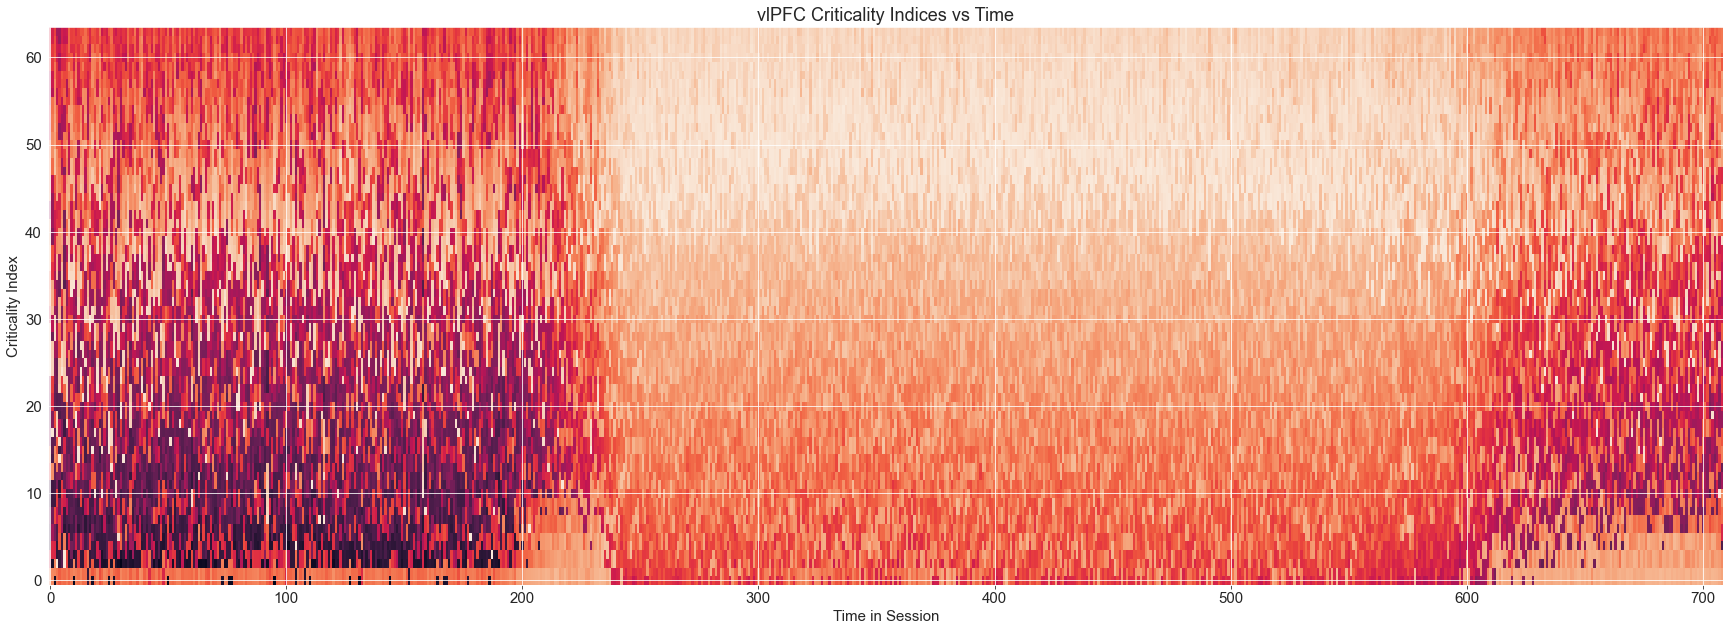

In [451]:
drug_inds = session_info['drugStart']*(1000/window)
plt.figure(figsize=(30,10))
plt.matshow(all_eigs_areas[0].T,origin='lower',fignum = 1,aspect='auto')
plt.gca().xaxis.tick_bottom()
plt.title('vlPFC Criticality Indices vs Time')
plt.xlabel('Time in Session')
plt.ylabel('Criticality Index')
#plt.vlines(drug_inds,0,50)
#plt.colorbar()
#plt.ylabel('Eigenvalue')


In [ ]:
plt.plot(results.fittedvalues[2])
plt.plot(lfp_chunk_df[2])
plt.legend(['Raw LFP, Electrode 1','VAR(1) Fit'])

In [ ]:
plt.plot(results.fittedvalues[2])


In [ ]:
import statsmodels.api as sm
from scipy.stats import norm

sm.qqplot(results.resid[4],line = 's')

In [ ]:
normality_res = results.test_normality(signif=0.05)

In [ ]:
normality_res.summary()